In [1]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph.message import add_messages
from typing import Annotated, Sequence, TypedDict, Literal
from langchain_core.tools import create_retriever_tool
from langchain_classic import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition, ToolNode


from dotenv import load_dotenv

load_dotenv()

# 크롤링할 웹 페이지 URL 목록
urls = [
    "https://finance.naver.com/",
    "https://finance.yahoo.com/",
    "https://finance.daum.net/",
]

# 각 URL에서 문서 로드
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# 문서 분할 설정
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# 벡터 스토어에 문서 추가
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()


# 에이전트 상태를 나타내는 데이터 구조 정의
class AgentState(TypedDict):
    # add_messages 함수는 업데이트가 어떻게 처리되어야 하는지 정의한다.
    # 기본값은 대체이다. add_messages는 "추가"라고 말한다.
    messages: Annotated[Sequence[BaseMessage], add_messages]


# 검색 도구 설정
retriever_tool = create_retriever_tool(
    retriever,
    "retriever_blog_posts",
    "네이버, 야후, 다음의 금융 관련 정보를 검색하고 반환한다.",
)
tools = [retriever_tool]


# Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    검색된 문서가 질문과 관련이 있는지 평가한다.

    Args:
      state (messages): 현재 상태

    Returns:
      str: 문서의 관련성에 따라 다음 노드 결정 ("generate" 또는 "rewrite")

    """
    print("---문서 관련성 평가---")

    # 데이터 모델 정의
    class grade(BaseModel):
        """관련성 평가를 위한 이진 점수."""

        binary_score: str = Field(description="관련성 점수 'yes' 또는 'no'")

    # LLM 모델 정의
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)

    # LLM에 데이터 모델 적용
    llm_with_tool = model.with_structured_output(grade)

    prompt = PromptTemplate(
        template="""
    당신은 사용자 질문에 대한 검색된 문서의 관련성을 평가하는 평가자입니다.\n
    여기 검색된 문서가 있습니다.:\n\n{context}\n\n
    여기 사용자 질문이 있습니다. {question}\n
    문서가 사용자 질문과 관련된 키워드 또는 의미를 포함하면 관련성이 있다고 평가해주세요.\n
    문서가 질문과 관련이 있는지 여부를 나타내기 위해 'yes' 또는 'no'로 이진 점수를 주세요
    """,
        input_variables=["context", "question"],
    )

    # 체인 생성
    chain = prompt | llm_with_tool

    messages = state["messages"]
    print("messages: ", messages)
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"context": docs, "question": question})

    score = scored_result.binary_score

    if score == "yes":
        print("---결정: 문서 관련성 있음---")
        return "generate"
    else:
        print("---결정: 문서 관련성 없음---")
        print(score)
        return "rewrite"


def agent(state):
    """
    현재 상태를 기반으로 에이전트 모델을 호출하여 응답을 생성한다.
    주어진 질문에 따라 검색 도구를 사용하여 검색을 수행하거나 단순히 종료하기로 결정한다.

    Args:
      state (messages): 현재 상태

    Returns:
      dict: 메시지에 에이전트 응답이 추가된 업데이트된 상태
    """
    print("---에이전트 호출---")
    messages = state["messages"]

    # 메시지가 제대로 전달되고 있는지 확인
    print("에이전트로 전달된 메시지들:", messages)

    model = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)
    model = model.bind_tools(tools)
    response = model.invoke(messages)

    # 응답을 상태에 추가
    state["messages"].append(response)
    return state


def rewrite(state):
    """
    질문을 재작성(변형)하여 더 나은 질문을 생성한다.

    Args:
      state (messages): 현재 상태

    Returns:
      dict: 재구성된 질문으로 업데이트된 상태
    """

    print("---질문 변형---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f"""
      다음 입력을 보고 근본적인 의도나 의미를 파악해보세요.\n 
      초기 질문은 다음과 같습니다:
      \n---------\n
      {question}
      \n---------\n
      개선된 질문을 만들어주세요:
      """
        )
    ]
    # 평가자
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)
    response = model.invoke(msg)

    # 반환되는 메시지가 올바른지 확인
    print("Rewrite 단계에서의 응답: ", response)
    # 상태 업데이트 - 기존 메시지에 새 메시지를 추가하여 상태를 업데이트
    state["messages"].append(response)
    return state


def generate(state):
    """
    답변 생성

    Args:
      state (messages): 현재 상태

    Returns:
      dict: 재구성된 질문으로 업데이트된 상태
    """
    print("---생성---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # 프롬프트
    # prompt = hub.pull("rlm/rag-prompt")
    # 프롬프트 정의
    prompt = PromptTemplate(
        template="""
    당신은 질문-답변 작업을 위한 어시스턴트 입니다.
    아래 제공된 문맥을 사용하여 질문에 답변해주세요.
    답을 모를 경우 '모르겠습니다'라고 말해주세요. 답변은 최대 3문장으로 간결하게 작성하세요.
    
    질문: {question}
    문맥: {context}
    답변: """,
        input_variables=["context", "question"],
    )
    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)
    # 체인
    rag_chain = prompt | llm | StrOutputParser()
    # 실행
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


# 새로운 그래프를 정의합니다.
workflow = StateGraph(AgentState)
# 순환할 노드들을 정의합니다.
workflow.add_node("agent", agent)  # 에이전트 노드
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # 검색 도구 노드
workflow.add_node("rewrite", rewrite)  # 질문 재작성 노드
workflow.add_node(
    "generate", generate
)  # 문서가 관련성이 있다고 판단된 후 응답 생성 노드

# 에이전트 노드를 호출하여 검색을 결정한다.
workflow.add_edge(START, "agent")

# 검색 여부를 결정한다.
workflow.add_conditional_edges(
    "agent",
    # 에이전트 결정 평가
    tools_condition,
    {
        # 조건 출력을 그래프 내 노드로 변환, 반환 값: 실행 노드
        "tools": "retrieve",
        END: "generate",
    },
)

# 검색 후 문서 관련성 평가
workflow.add_conditional_edges(
    "retrieve",
    # 에이전트 결정 평가
    grade_documents,
    {
        # 조건 출력을 그래프 내 노드로 변환, 반환 값: 실행 노드
        "generate": "generate",
        "rewrite": "rewrite",
    },
)

workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# 컴파일
graph = workflow.compile()


/Users/93minki/Desktop/Study/langchain-book/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


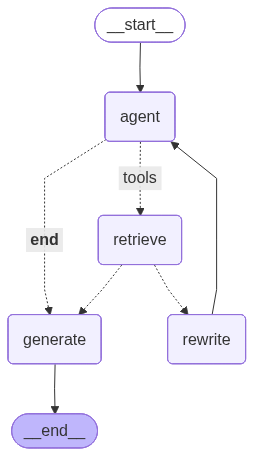

In [2]:
from IPython.display import Image, display 
try:
  display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
  pass

In [4]:
import pprint 
inputs = {
  "messages": [
    ("user","삼성전자 주가?")
  ]
}

for output in graph.stream(inputs):
  for key, value in output.items():
    pprint.pprint(f"노드 '{key}'의 출력 결과:")
    pprint.pprint("---")
    pprint.pprint(value, indent=2, width=80, depth=None)
  pprint.pprint("---")

---에이전트 호출---
에이전트로 전달된 메시지들: [HumanMessage(content='삼성전자 주가?', additional_kwargs={}, response_metadata={}, id='1c9e943e-364f-4af8-8cbf-f10bcf8d9db1')]
"노드 'agent'의 출력 결과:"
'---'
{ 'messages': [ HumanMessage(content='삼성전자 주가?', additional_kwargs={}, response_metadata={}, id='1c9e943e-364f-4af8-8cbf-f10bcf8d9db1'),
                AIMessage(content='', additional_kwargs={}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'service_tier': 'default', 'model_provider': 'openai'}, id='lc_run--2793ea62-fcc2-41e0-9c65-5c773a6d4fcc', tool_calls=[{'name': 'retriever_blog_posts', 'args': {'query': '삼성전자 주가'}, 'id': 'call_RSJltpu1m70fPeOSokQxDLDO', 'type': 'tool_call'}], usage_metadata={'input_tokens': 70, 'output_tokens': 21, 'total_tokens': 91, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
'---'
---문서 관련성 평가---
messages:  [HumanMessage(content='삼성전자 주가